In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from bgd_regression import BGDRegression
from sgd_regression import SGDRegression
from logistic_regression import LogisticRegression

In [2]:
def load_features(df: pd.DataFrame, input_names: list, output_names: str) -> tuple:
    """
    Load features from a csv file.
    :param df: DataFrame containing.
    :param input_names: List containing the names of the inputs.
    :param output_names: String containing the name of the output.
    :return: 
    """
    # Check if the input names are in the features
    for name in input_names:
        if name not in df.columns:
            raise ValueError(f'Input name {name} not found in the features.')

    # Check if the output name is in the features
    if output_names not in df.columns:
        raise ValueError(f'Output name {output_names} not found in the features.')

    # Returning a list containing only the input features and the list of output feature values.
    return [df[name].values.tolist() for name in input_names], df[output_names].values.tolist()


def handle_missing_data(df: pd.DataFrame):
    """
    Handle missing data by filling it with the mean of the column.
    :param df: DataFrame containing the data read.
    :return: None
    """
    df.fillna(df.select_dtypes(include=['float64', 'int64']).mean(), inplace=True)


def split_data(inputs: list, outputs: list) -> tuple:
    """
    Splits the inputs and outputs into training and validation sets.
    :param inputs: List containing the input features.
    :param outputs: List containing the output features.
    :return: Tuple containing the training and validation inputs and outputs.
    """
    # Splitting the data into training and validation sets
    np.random.seed(5)

    indexes = [i for i in range(len(inputs[0]))]

    train_sample = np.random.choice(indexes, int(0.8 * len(inputs[0])), replace=False)
    validation_sample = [i for i in indexes if i not in train_sample]

    train_inputs = [[inputs[j][i] for i in train_sample] for j in range(len(inputs))]
    train_outputs = [outputs[i] for i in train_sample]

    validation_inputs = [[inputs[j][i] for i in validation_sample] for j in range(len(inputs))]
    validation_outputs = [outputs[i] for i in validation_sample]

    return train_inputs, train_outputs, validation_inputs, validation_outputs


def normalize_data(train: list, test: list) -> tuple:
    """
    Normalizes the data.
    :param train: List containing the training values of the features.
    :param test: List containing the test values of the features.
    :return: Tuple containing the normalized training and test features.
    """

    scaler = StandardScaler()

    if isinstance(train[0], list):
        scaler.fit(np.transpose(train))
        
        n_inputs = np.transpose(scaler.transform(np.transpose(train))).tolist()
        n_outputs = np.transpose(scaler.transform(np.transpose(test))).tolist()
    else:
        scaler.fit(np.transpose([train]))
        n_inputs = np.transpose(scaler.transform(np.transpose([train]))).tolist()[0]
        n_outputs = np.transpose(scaler.transform(np.transpose([test]))).tolist()[0]

    return n_inputs, n_outputs

In [3]:
def train_model(regressor, t_in: list, t_out: list) -> tuple:
    """
    Train the model using a SGDRegressor.
    :param regressor: Regressor to use.
    :param t_in: Training inputs.
    :param t_out: Training outputs.
    :return: Tuple containing the coefficients determined by the model.
    """

    # Reshaping the input features into a line matrix.
    zipped = zip(*t_in)
    xx = [[*el] for el in zipped]

    # Reshaping the output features into a line matrix.
    yy = t_out

    # Training the model.
    regressor.fit(xx, yy)

    # Extracting the coefficients.
    w0, w = regressor.intercept_[0], regressor.coef_.tolist()
    return w0, w


def compute_model(t_in: list, w0: float, w: list) -> tuple:
    """
    Compute the output using the model.
    :param t_in: Training inputs.
    :param w0: Intercept.
    :param w: Coefficients.
    :return: List containing the computed outputs.
    """
    mins, maxs = [], []

    for i in range(len(t_in)):
        mins.append(min(t_in[i]))
        maxs.append(max(t_in[i]))

    no_of_points = 100
    epsilon = 0.1
    xref = np.meshgrid(
        *[np.arange(mins[i], maxs[i] + 0.1, (maxs[i] - mins[i] + epsilon) / no_of_points) for i in range(len(t_in))])

    yref = w0
    for i in range(len(t_in)):
        yref += w[i] * xref[i]

    return xref, [yref]


def predict_model(regressor, v_in: list) -> list:
    """
    Predict the output using the model.
    :param regressor: Regressor to use.
    :param v_in: Validation inputs.
    :return: List containing the predicted outputs.
    """
    # Reshaping the input features into a line matrix.
    zipped = zip(*v_in)
    xx = [[*el] for el in zipped]

    # Predicting the output.
    return [regressor.predict(xx)]


def predict_classifier(regressor: linear_model.LogisticRegression, v_in: list, no_classes: int) -> list:
    """
    Predicts the probabilities of the classes.
    :param regressor: Regressor to use.
    :param v_in: Validation inputs.
    :param no_classes: Number of classes that the classifier has to predict.
    :return: List containing the predicted outputs.
    """
    # Reshaping the input features into a line matrix.
    zipped = zip(*v_in)
    xx = [[*el] for el in zipped]

    # Predicting the output.
    probabilities = regressor.predict_proba(xx)
    threshold = 1 / no_classes

    return [1 if el[1] > threshold else 0 for el in probabilities]


def mse(c_out: list, v_out: list):
    """
    Compute the error between the computed and the validation outputs using MSE.
    :param c_out: Computed outputs.
    :param v_out: Validation outputs.
    :return: The error between the computed and the validation outputs.
    """
    error = 0.0
    for t1, t2 in zip(c_out, v_out):
        error += (t1 - t2) ** 2
    error /= len(c_out)
    return error


def msle(c_out: list, v_out: list):
    """
    Compute the error between the computed and the validation outputs using Mean Squared Logarithmic Error.
    :param c_out: Computed outputs.
    :param v_out: Validation outputs.
    :return: The error between the computed and the validation outputs.
    """
    
    error = 0.0
    for t1, t2 in zip(c_out, v_out):
        error += (np.log(abs(t1) + 1) - np.log(abs(t2) + 1)) ** 2
    
    error /= len(c_out)
    return error

def mae(c_out: list, v_out: list):
    """
    Compute the error between the computed and the validation outputs using Mean Absolute Error.
    :param c_out: Computed outputs.
    :param v_out: Validation outputs.
    :return: The error between the computed and the validation outputs.
    """
    error = 0.0
    for t1, t2 in zip(c_out, v_out):
        error += abs(t1 - t2)
    error /= len(c_out)
    return error

def bce(c_out: list, v_out: list):
    """
    Compute the error between the computed and the validation outputs using Binary Cross Entropy.
    :param c_out: Computed outputs.
    :param v_out: Validation outputs.
    :return: The error between the computed and the validation outputs.
    """
    error = 0.0
    for t1, t2 in zip(c_out, v_out):
        error += -(t2 * np.log(t1 + 1) + (1 - t2) * np.log(1 - t1 + 1))
    error /= len(c_out)
    return abs(error)

def hinge_loss(c_out: list, v_out: list):
    """
    Compute the error between the computed and the validation outputs using Hinge Loss.
    :param c_out: Computed outputs.
    :param v_out: Validation outputs.
    :return: The error between the computed and the validation outputs.
    """
    error = 0.0
    for t1, t2 in zip(c_out, v_out):
        error += max(0, 1 - t1 * t2)
    error /= len(c_out)
    return error

In [14]:
def plot_data_one_feature(t_in: list = None, t_out: list = None, v_in: list = None, v_out: list = None,
                          c_in: list = None, c_out: list = None, m_in: list = None, m_out: list = None,
                          title: str = None):
    """
    Plot the data for one feature.
    :param m_in: 
    :param m_out: 
    :param t_in: Training inputs.
    :param t_out: Training outputs.
    :param v_in: Validation inputs.
    :param v_out: Validation outputs.
    :param c_in: Computed inputs.
    :param c_out: Computed outputs. 
    :param m_in: Model inputs.
    :param m_out: Model outputs.
    :param title: Title of the plot.
    :return: None
    """

    # Plotting the training data and the validation data.
    if t_in and v_in:
        plt.scatter(t_in[0], t_out, marker='o', color='blue', label='Training Data')
        plt.scatter(v_in[0], v_out, marker='x', color='yellow', label='Validation Data')

    if t_in and v_in:
        plt.scatter(t_in[0], t_out, alpha=1.0, marker='o', color='darkorange', label='Training data')
        plt.scatter(v_in[0], v_out, alpha=1.0, marker='^', color='green', label='Validation data')
    if t_in and m_in:
        plt.scatter(t_in[0], t_out, alpha=1.0, marker='o', color='darkorange', label='Training data')
        plt.plot(m_in[0], m_out[0], 'b-', label='Model data')
    if c_in and v_in:
        plt.scatter(c_in[0], c_out, alpha=1.0, marker='o', color='red', label='Computed data')
        plt.scatter(v_in[0], v_out, alpha=1.0, marker='^', color='green', label='Real data')

    plt.xlabel("Economy..GDP.per.Capita.")
    plt.ylabel("Happiness.Score")

    plt.title(title)
    plt.legend()
    plt.show()


def plot_data_two_features(t_in: list = None, t_out: list = None, v_in: list = None, v_out: list = None,
                           c_in: list = None, c_out: list = None, m_in: list = None, m_out: list = None,
                           title: str = None):
    """
    Plot the data for two features.
    :param t_in: Training inputs.
    :param t_out: Training outputs.
    :param v_in: Validation inputs.
    :param v_out: Validation outputs.
    :param c_in: Computed inputs.
    :param c_out: Computed outputs (predictions).
    :param m_in: Model inputs.
    :param m_out: Model outputs.
    :param title: Title of the plot
    :return: None
    """
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')

    if t_in and v_in:
        ax.scatter(t_in[0], t_in[1], t_out[0], alpha=1.0, marker='o', color='darkorange', label='Training data')
        ax.scatter(v_in[0], v_in[1], v_out[0], alpha=1.0, marker='^', color='green', label='Validation data')
    if t_in and m_in:
        ax.scatter(t_in[0], t_in[1], t_out[0], alpha=1.0, marker='o', color='darkorange', label='Training data')
        ax.plot_surface(m_in[0], m_in[1], m_out[0], alpha=0.7, color='lightblue', label='Model data')
    if c_in and v_in:
        ax.scatter(c_in[0], c_in[1], c_out[0], alpha=1.0, marker='o', color='red', label='Computed data')
        ax.scatter(v_in[0], v_in[1], v_out[0], alpha=1.0, marker='^', color='green', label='Real data')

    ax.set_xlabel('GDP')
    ax.set_ylabel('Freedom')
    ax.set_zlabel('Happiness')

    plt.title(title)
    ax.legend()
    plt.show()

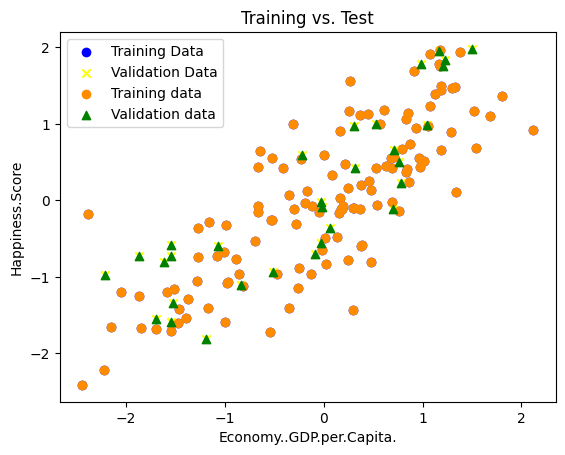

Intercept = -0.011391681996385222 | Coefficients = [0.8006475712571498]

[array([-2.44000749, -2.39341603, -2.34682457, -2.3002331 , -2.25364164,
       -2.20705018, -2.16045871, -2.11386725, -2.06727579, -2.02068432,
       -1.97409286, -1.9275014 , -1.88090994, -1.83431847, -1.78772701,
       -1.74113555, -1.69454408, -1.64795262, -1.60136116, -1.5547697 ,
       -1.50817823, -1.46158677, -1.41499531, -1.36840384, -1.32181238,
       -1.27522092, -1.22862945, -1.18203799, -1.13544653, -1.08885507,
       -1.0422636 , -0.99567214, -0.94908068, -0.90248921, -0.85589775,
       -0.80930629, -0.76271483, -0.71612336, -0.6695319 , -0.62294044,
       -0.57634897, -0.52975751, -0.48316605, -0.43657458, -0.38998312,
       -0.34339166, -0.2968002 , -0.25020873, -0.20361727, -0.15702581,
       -0.11043434, -0.06384288, -0.01725142,  0.02934004,  0.07593151,
        0.12252297,  0.16911443,  0.2157059 ,  0.26229736,  0.30888882,
        0.35548029,  0.40207175,  0.44866321,  0.49525467,  0.

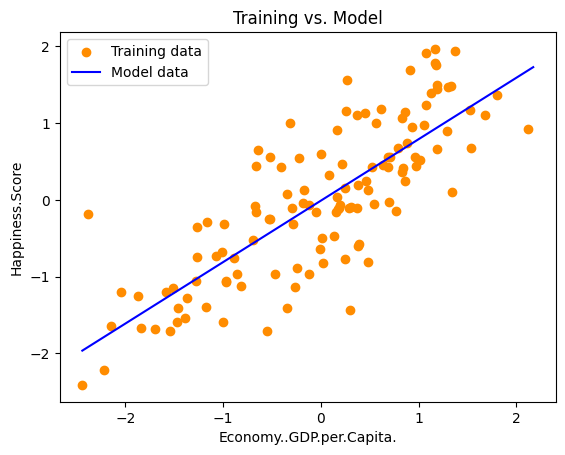

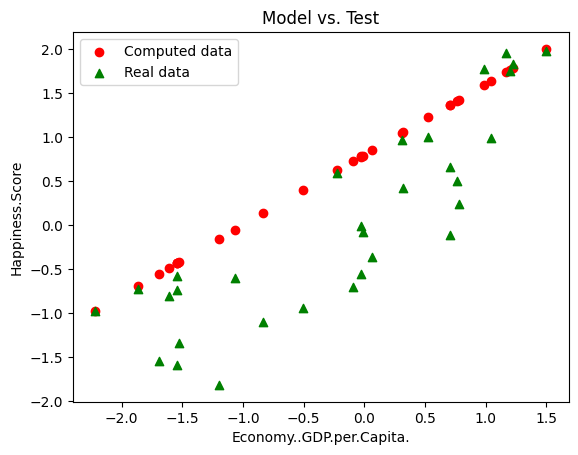

Error (mse) = 0.721445189624442
Error (msle) = 0.15082459962471265
Error (mae) = 0.6675719411771583
Error (tool mse) = 0.721445189624442



In [20]:
def main_gdp(regressor):
    df = pd.read_csv("data/world-happiness-report-2017.csv")
    handle_missing_data(df)

    inputs, outputs = load_features(df, ["Economy..GDP.per.Capita."], "Happiness.Score")

    X_train, y_train, X_test, y_test = split_data(inputs, outputs)
    X_train, X_test = normalize_data(X_train, X_test)
    y_train, y_test = normalize_data(y_train, y_test)
    
    plot_data_one_feature(t_in=X_train, t_out=y_train, v_in=X_test, v_out=y_test, title="Training vs. Test")

    w0, w = train_model(regressor, X_train, y_train)
    print(f"Intercept = {w0} | Coefficients = {w}\n")

    m_in, m_out = compute_model(X_train, w0, w)
    plot_data_one_feature(t_in=X_train, t_out=y_train, m_in=m_in, m_out=m_out, title="Training vs. Model")

    c_out = predict_model(regressor, X_test)
    plot_data_one_feature(v_in=X_test, v_out=y_test, c_in=X_test, c_out=c_out, title="Model vs. Test")

    print(f"Error (mse) = {mse(c_out[0], y_test)}")
    print(f"Error (msle) = {msle(c_out[0], y_test)}")
    print(f"Error (mae) = {mae(c_out[0], y_test)}")
    print(f"Error (tool mse) = {metrics.mean_squared_error(c_out[0], y_test)}\n")


def main_gdp_freedom(regressor):
    df = pd.read_csv("data/world-happiness-report-2017.csv")
    handle_missing_data(df)

    inputs, outputs = load_features(df, ["Economy..GDP.per.Capita.", "Freedom"], "Happiness.Score")

    X_train, y_train, X_test, y_test = split_data(inputs, outputs)
    X_train, X_test = normalize_data(X_train, X_test)
    y_train, y_test = normalize_data(y_train, y_test)
    plot_data_two_features(t_in=X_train, t_out=y_train, v_in=X_test, v_out=y_test, title="Training vs. Test")

    w0, w = train_model(regressor, X_train, y_train)
    print(f"Intercept = {w0} | Coefficients = {w}\n")

    m_in, m_out = compute_model(X_train, w0, w)
    plot_data_two_features(t_in=X_train, t_out=y_train, m_in=m_in, m_out=m_out, title="Training vs. Model")

    c_out = predict_model(regressor, X_test)
    plot_data_two_features(c_in=X_test, c_out=c_out, v_in=X_test, v_out=y_test, title="Model vs. Test")

    print(f"Error (mse) = {mse(c_out[0], y_test)}")
    print(f"Error (msle) = {msle(c_out[0], y_test)}")
    print(f"Error (mae) = {mae(c_out[0], y_test)}")
    print(f"Error (tool mse) = {metrics.mean_squared_error(c_out[0], y_test)}\n")


#_regressor = linear_model.SGDRegressor(max_iter=1000, alpha=0.01)
#_regressor = BGDRegression()
_regressor = SGDRegression()

main_gdp(_regressor)
#main_gdp_freedom(_regressor)

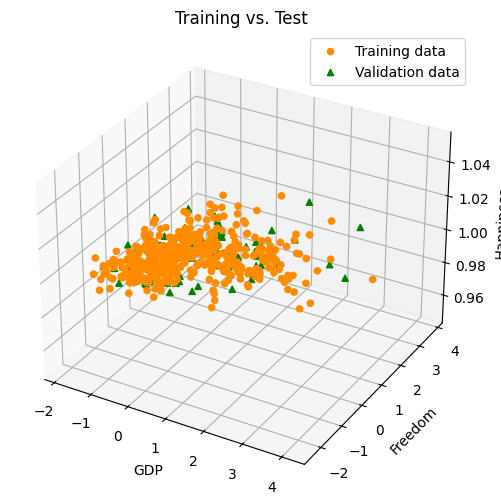

Intercept = -0.3264428267314845 | Coefficients = [6.871729367484151, 1.1662997757932543]



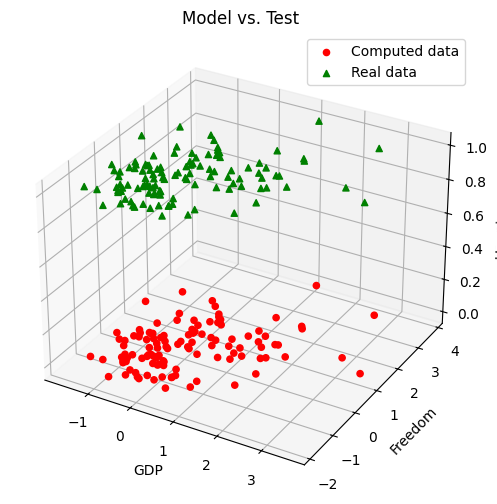

Error (bce) = 0.4985795509290837
Error (hinge_loss) = 0.6578947368421053


In [28]:
def load_cancer_data(df: pd.DataFrame):
    '''
    Load the breast cancer data.
    :param df: 
    :return: 
    '''
    radius = [df["radius" + str(i)].values.tolist() for i in range(1, 4)]
    texture = [df["texture" + str(i)].values.tolist() for i in range(1, 4)]

    mean_radius = [np.mean([radius[i][j] for i in range(3)]) for j in range(len(radius[0]))]
    mean_texture = [np.mean([texture[i][j] for i in range(3)]) for j in range(len(texture[0]))]

    return [mean_radius, mean_texture], df["Diagnosis"].values.tolist()

def main_breast_cancer(regressor):
    df = pd.read_csv("data/wdbc.data")
    handle_missing_data(df)

    inputs, outputs = load_cancer_data(df)
    
    le = LabelEncoder()
    outputs = le.fit_transform(outputs).tolist()

    X_train, y_train, X_test, y_test = split_data(inputs, outputs)
    X_train, X_test = normalize_data(X_train, X_test)
    plot_data_two_features(t_in=X_train, t_out=y_train, v_in=X_test, v_out=y_test, title="Training vs. Test")

    w0, w = train_model(regressor, X_train, y_train)
    print(f"Intercept = {w0} | Coefficients = {w}\n")

    c_out = predict_classifier(regressor, X_test, 2)
    plot_data_two_features(c_in=X_test, c_out=c_out, v_in=X_test, v_out=y_test, title="Model vs. Test")
    
    print(f"Error (bce) = {bce(c_out, y_test)}")
    print(f"Error (hinge_loss) = {hinge_loss(c_out, y_test)}")


#_regressor = linear_model.LogisticRegression(max_iter=1000)
#_regressor = LogisticRegression(0.7)
_regressor = LogisticRegression(0.5)
#_regressor = LogisticRegression(0.3)
main_breast_cancer(_regressor)

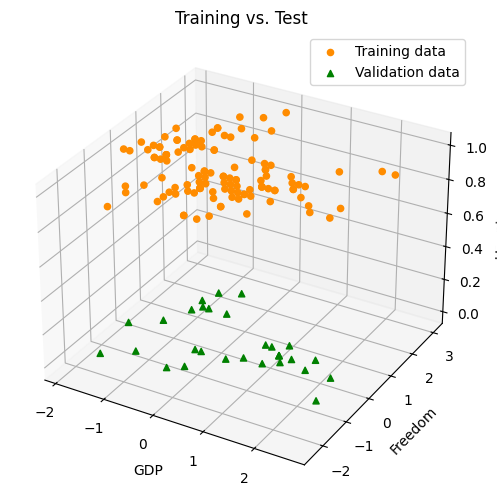

/home/culbec/facultate/AI/lab6/SGD/logistic_regression.py:15: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Intercept = 11752.787848423774 | Coefficients = [10159.106595772775, -2518.635057232931, 11532.691357526417, 12356.481077030114]



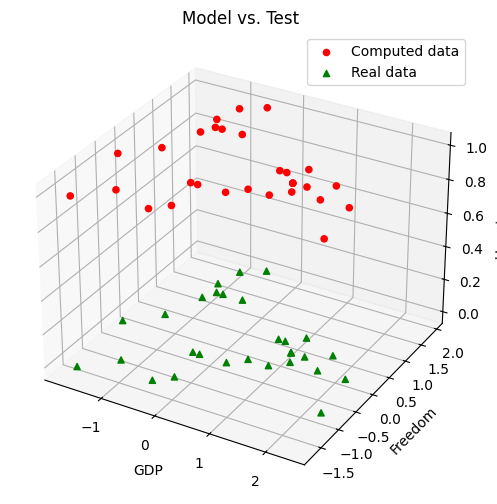

Error (bce) = 0.1617343421306539
Error (hinge_loss) = 0.7333333333333333


In [30]:
def load_iris_data(df: pd.DataFrame):
    '''
    Load the iris data.
    :param df: 
    :return: 
    '''
    sepal_length = df["sepal_length"].values.tolist()
    sepal_width = df["sepal_width"].values.tolist()
    petal_length = df["petal_length"].values.tolist()
    petal_width = df["petal_width"].values.tolist()

    return [sepal_length, sepal_width, petal_length, petal_width], df["class"].values.tolist()

def main_iris(regressor):
    df = pd.read_csv("data/iris.data")
    handle_missing_data(df)

    inputs, outputs = load_iris_data(df)

    le = LabelEncoder()
    outputs = le.fit_transform(outputs).tolist()

    X_train, y_train, X_test, y_test = split_data(inputs, outputs)
    X_train, X_test = normalize_data(X_train, X_test)
    plot_data_two_features(t_in=X_train, t_out=y_train, v_in=X_test, v_out=y_test, title="Training vs. Test")

    w0, w = train_model(regressor, X_train, y_train)
    print(f"Intercept = {w0} | Coefficients = {w}\n")

    c_out = predict_classifier(regressor, X_test, 2)
    plot_data_two_features(c_in=X_test, c_out=c_out, v_in=X_test, v_out=y_test, title="Model vs. Test")

    print(f"Error (bce) = {bce(c_out, y_test)}")
    print(f"Error (hinge_loss) = {hinge_loss(c_out, y_test)}")

#_regressor = linear_model.LogisticRegression(max_iter=1000)
#_regressor = LogisticRegression(0.7)
#_regressor = LogisticRegression(0.5)
_regressor = LogisticRegression(0.3)
main_iris(_regressor)

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validation(model, x, y, num_splits=5):
    """
    Perform cross-validation.
    :param model: Model to use.
    :param x: Inputs.
    :param y: Outputs
    :param num_splits: Number of data set splits 
    :return: Mean accuracy of the model.
    """
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    accuracies = []

    errors = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        errors.append(accuracy)
        accuracies.append(accuracy)

    return np.mean(accuracies)

def main_iris_cross_validation(regressor):
    df = pd.read_csv("data/iris.data")
    handle_missing_data(df)

    inputs, outputs = load_iris_data(df)

    le = LabelEncoder()
    outputs = le.fit_transform(outputs).tolist()

    X = np.array(inputs).T
    y = np.array(outputs)

    print(f"Accuracy = {cross_validation(regressor, X, y)}")

_regressor = linear_model.LogisticRegression(max_iter=1000)
main_iris_cross_validation(_regressor)

Accuracy = 0.9733333333333334
